# MiniProject - Variant 3 - Group M

## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

import sklearn
from sklearn.preprocessing import StandardScaler
import time
import mat73 # requires pip install mat73

import pandas as pd
from align import align

## Loading data

In [5]:
n_subject = 1

sub_files = []
emg = []
for i in range(1, n_subject+1):
    sub_files.append(mat73.loadmat('sub/s' + str(i) + '.mat'))
    print("The type of the file nb " + str(i) + " is: " + str(type(sub_files[i-1])))
    print("The keys of the file nb " + str(i) + " are: " + str(sub_files[i-1].keys()))
    print("\n\n")


The type of the file nb 1 is: <class 'dict'>
The keys of the file nb 1 are: dict_keys(['Fs', 'adjusted_class', 'adjusted_label', 'adjusted_repetition', 'class', 'emg_extensors', 'emg_flexors', 'force', 'label', 'outlier_scores_extensors', 'outlier_scores_flexors', 'repetition', 'subject'])





In [59]:
sub_files[0]['adjusted_label'].shape

(6752691, 16)

In [42]:
Fs = sub_files[0]['Fs'][()]
# print("Fs is ", Fs)
repetition = sub_files[0]['repetition']
# print("Repetition is ", repetition)
adjusted_class = sub_files[0]['adjusted_class']
# print("Adjusted classes is ", adjusted_classes)
adjusted_label = sub_files[0]['adjusted_label']
# print("Adjusted labels is ", adjusted_labels)
adjusted_repetition = sub_files[0]['adjusted_repetition']

emg_extensors = sub_files[0]['emg_extensors'] 
emg_flexors = sub_files[0]['emg_flexors']
force = sub_files[0]['force'] 

## Part 1

### Preprocessing the data


In [46]:

print(f'What are the shape of the data that we are working with? EMG_extensors: {emg_extensors.shape}, EMG_flexors {emg_flexors.shape}, adjusted_epetition {adjusted_repetition.shape}')

What are the shape of the data that we are working with? EMG_extensors: (6752691, 8, 8), EMG_flexors (6752691, 8, 8), adjusted_epetition (6752691,)


In [51]:
n_repetitions = len(np.unique(adjusted_repetition)) - 1 # -1 because 0 is not a repetition
n_stimuli = len(np.unique(adjusted_class)) - 1 # -1 because 0 is not a repetition
n_channels = emg_extensors.shape[1]*emg_extensors.shape[2]

emg_extensors_reshaped = np.reshape(emg_extensors, (emg_extensors.shape[0], n_channels))
emg_flexors_reshaped = np.reshape(emg_flexors, (emg_flexors.shape[0], n_channels))
print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 65
How many repetitions are there? 5


In [53]:
emg_extensors_reshaped.shape

(6752691, 64)

### Visualizing the data

In [54]:
## what are the stimulis here ? 

number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for i in range(n_stimuli):
    for j in range(n_repetitions):
        
        idx = np.logical_and(adjusted_class == i+1, repetition == j+1)
        number_of_samples_per_trial[i, j] = np.sum(idx.astype(int))
        
number_of_samples_per_trial


array([[ 7893.,  7986.,  7983.,  7714.,  7861.],
       [ 8329.,  8183.,  8623.,  8397.,  8049.],
       [ 8356.,  8649.,  8113.,  8129.,  8441.],
       [ 8821.,  8374.,  8413.,  8026.,  8159.],
       [ 8035.,  8645.,  8250.,  8028.,  7808.],
       [ 8338.,  8441.,  8676.,  8719.,  8532.],
       [ 8227.,  7997.,  7974.,  8125.,  8211.],
       [ 8502.,  8368.,  8545.,  8483.,  8337.],
       [ 8343.,  8214.,  8550.,  8081.,  7965.],
       [ 8584.,  8176.,  8208.,  8845.,  8572.],
       [ 8714.,  8997.,  8242.,  8035.,  8271.],
       [ 8582.,  9084.,  8446.,  8407.,  8040.],
       [ 8235.,  8374.,  8496.,  8186.,  7600.],
       [ 7092.,  8412.,  7963.,  7666.,  8775.],
       [ 8446.,  8175.,  7984.,  8689.,  8549.],
       [ 8214.,  8325.,  8986.,  9183.,  7944.],
       [ 7763.,  8191.,  8353.,  8444.,  7660.],
       [ 8360.,  7989.,  8178.,  7637.,  7991.],
       [ 8451.,  8378.,  8763.,  8964.,  7134.],
       [ 8820.,  8615.,  6672.,  6753.,  9065.],
       [ 8688.,  899

In [ ]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]
emg_rectified = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]
emg_envelopes = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]

for i in range(n_stimuli):
    for j in range(n_repetitions):

        idx = np.logical_and(adjusted_class == i + 1, adjusted_repetition == j + 1).flatten()
        emg_windows[i][j] = emg_extensors_reshaped[idx, :]
        emg_rectified[i][j] = np.abs(emg_windows[i][j])
        emg_envelopes[i][j] = convolve1d(emg_rectified[i][j], mov_mean_weights, axis=0)


Text(0.5, 0.98, 'Windowned EMG signal')

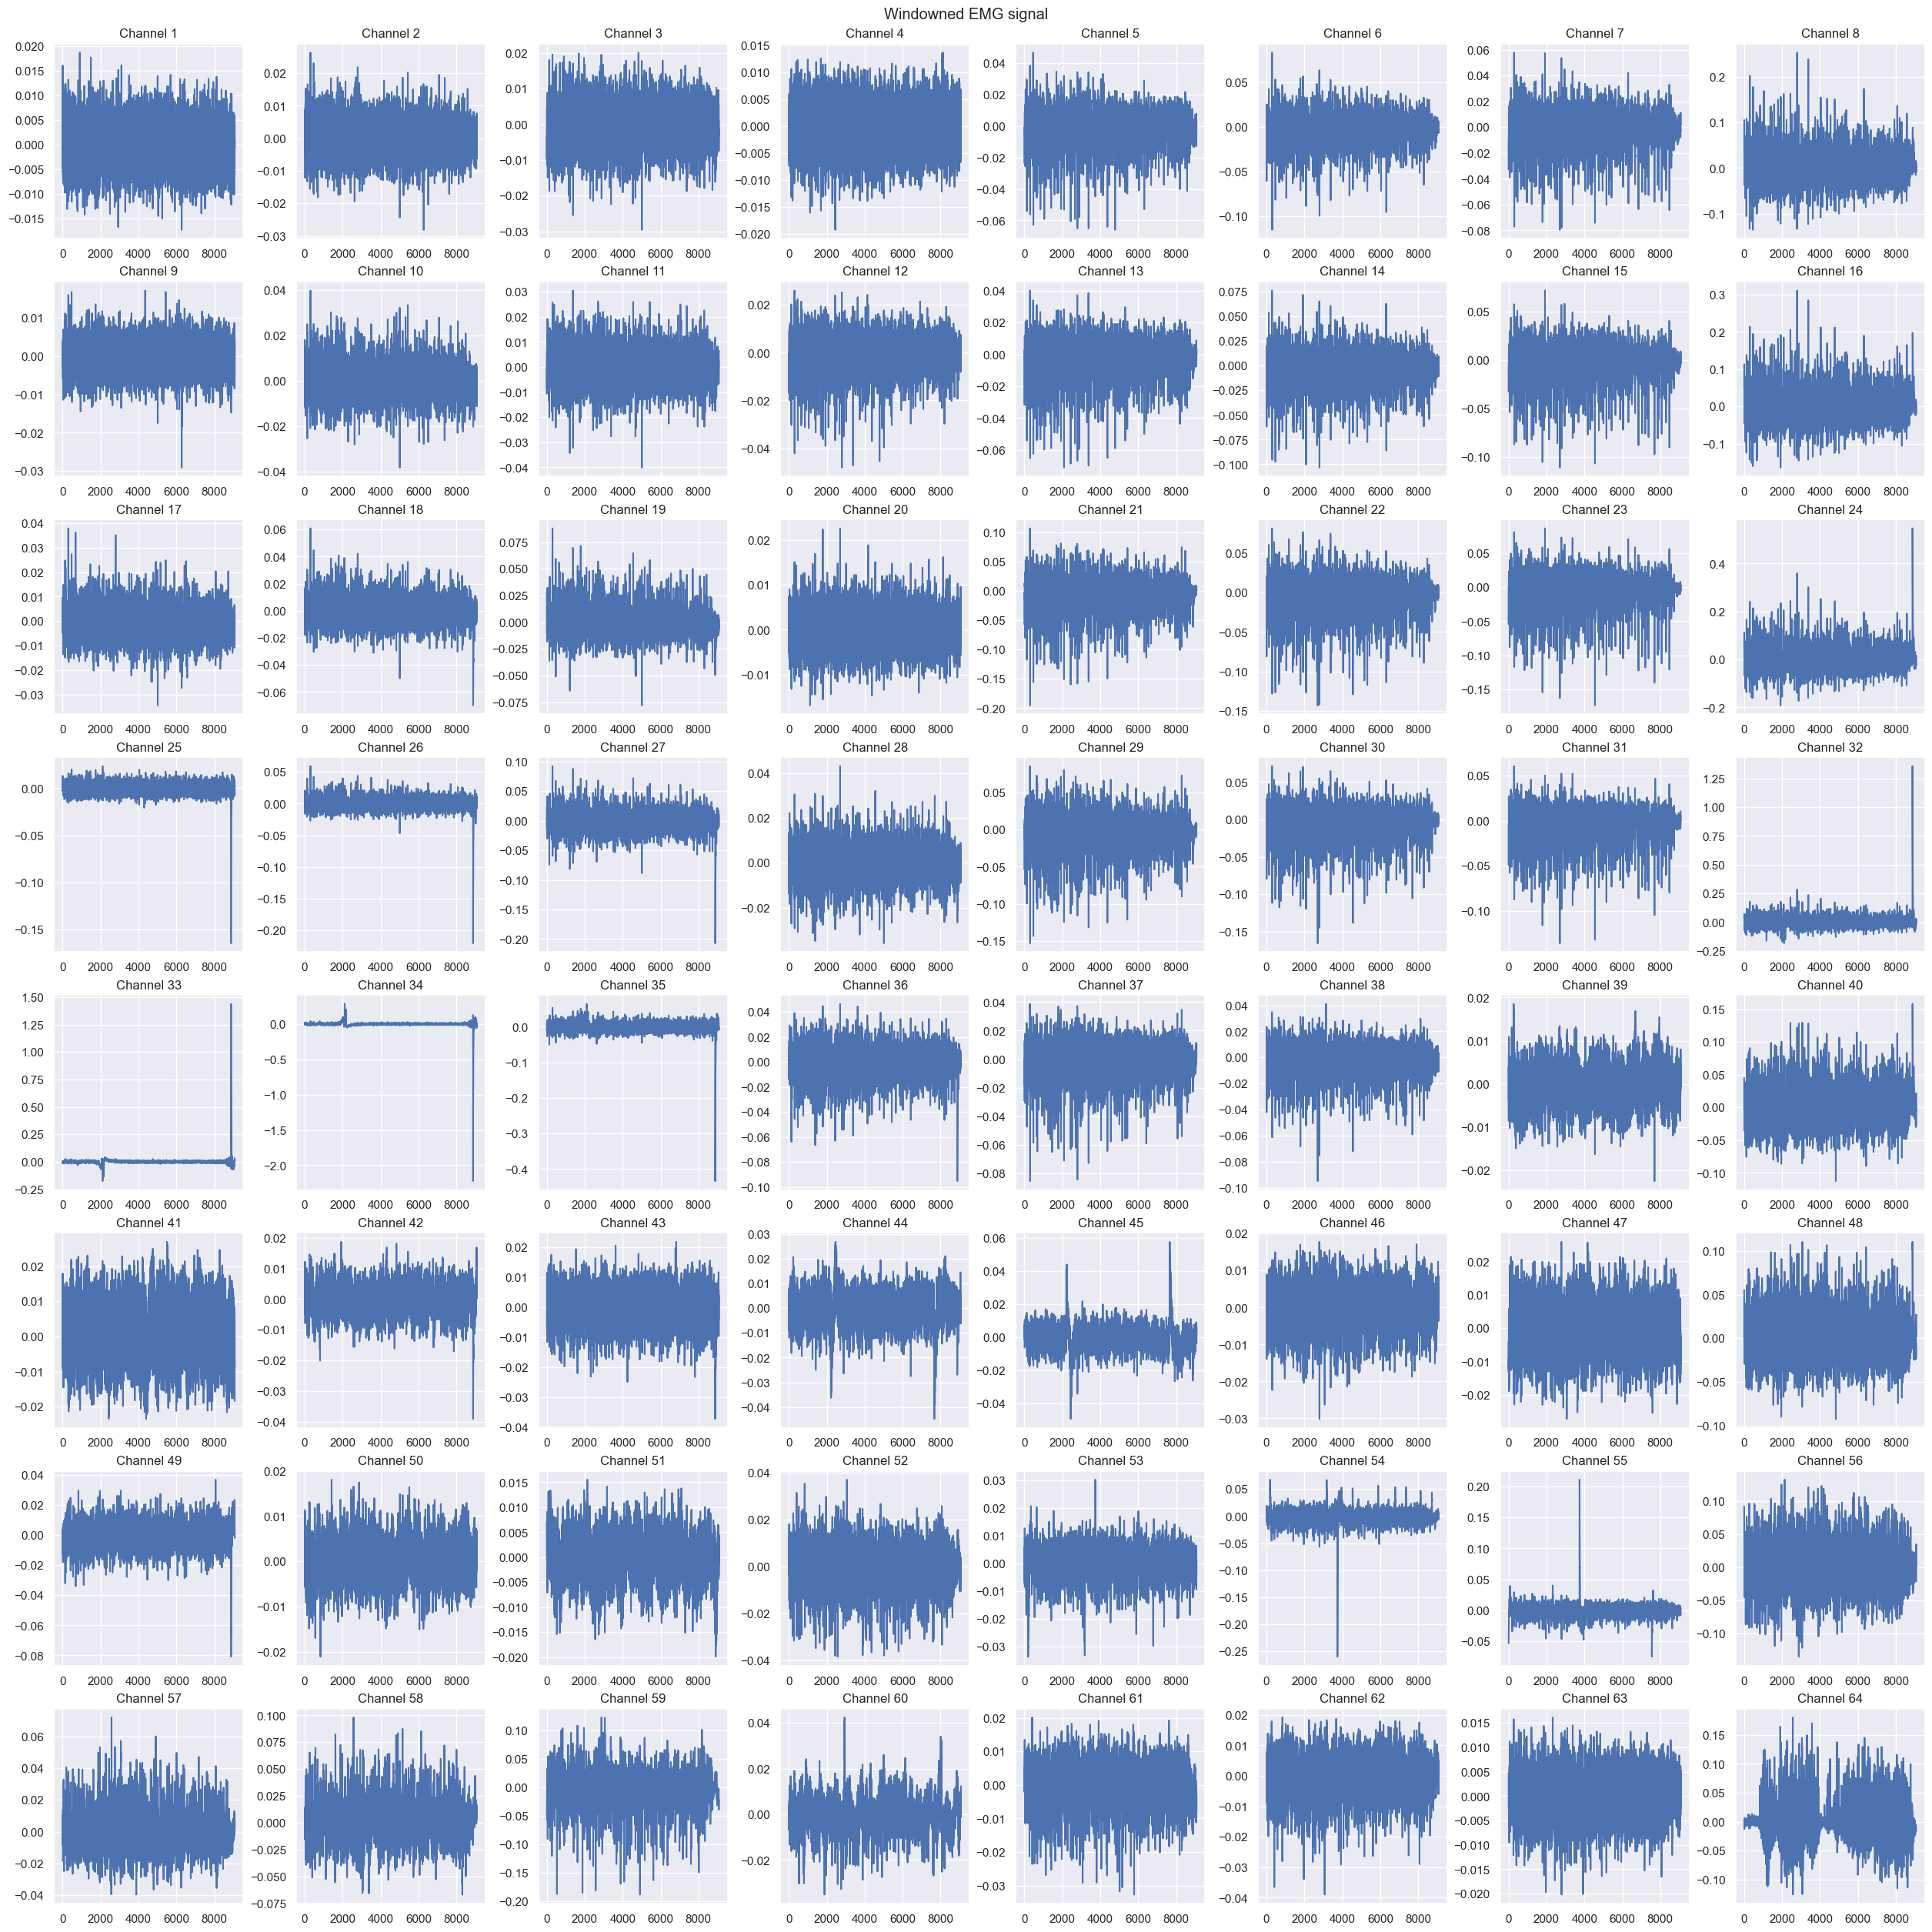

In [57]:

fig, ax = plt.subplots(8, 8, figsize=(25, 25), constrained_layout=True)
ax = ax.ravel()
for i in range(n_channels):
    ax[i].plot(emg_windows[0][0][:, i])
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Windowned EMG signal")

## Part 2

### Spatial synergies using BSS

## Part 3


### Comparison

## Part 4



## Part 5

## Part 6
